abtract: từ B5 ta thấy chỉ có thuật toán LG là fit với DB 03 bây giờ ta sẽ improve các hyperparameter của thuật toán LG

In [1]:
#load data 02
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
db=pd.read_csv("../../data/processed/DB03.csv")

In [2]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69057 entries, 0 to 69056
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                69057 non-null  float64
 1   HighChol              69057 non-null  float64
 2   CholCheck             69057 non-null  float64
 3   BMI                   69057 non-null  float64
 4   Stroke                69057 non-null  float64
 5   HeartDiseaseorAttack  69057 non-null  float64
 6   AnyHealthcare         69057 non-null  float64
 7   NoDocbcCost           69057 non-null  float64
 8   GenHlth               69057 non-null  float64
 9   DiffWalk              69057 non-null  float64
 10  Sex                   69057 non-null  float64
 11  Age                   69057 non-null  float64
 12  Diabetes              69057 non-null  float64
dtypes: float64(13)
memory usage: 6.8 MB


In [3]:
#chuẩn bị data để huân luyện 
from sklearn.model_selection import train_test_split
x=db.drop('Diabetes',axis=1)
y=db['Diabetes']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [4]:
cols_to_scale = ['BMI', 'GenHlth', 'Age']

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train[cols_to_scale] = scaler.fit_transform(x_train[cols_to_scale])

In [6]:
x_test[cols_to_scale]=scaler.transform(x_test[cols_to_scale])

In [7]:
#đánh giá training bới cross-validation với k-fold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,f1_score,classification_report, confusion_matrix, accuracy_score
# Hàm đánh giá mô hình với các chỉ số chung
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Cross-validation với k=5 và tiêu chí đánh giá là 'accuracy'
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    print(f"{model.__class__.__name__} - Cross-validation scores:", cv_scores)
    print(f"Mean cross-validation score: {cv_scores.mean()}\n")
    
    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(x_test)
    
    # Các chỉ số đánh giá trên tập kiểm tra
    print(f"{model.__class__.__name__} - Accuracy Score:", accuracy_score(y_test, y_pred))
    print(f"{model.__class__.__name__} - F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print(f"{model.__class__.__name__} - Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{model.__class__.__name__} - Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 50)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_lg = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['liblinear'],
        'class_weight': [None, 'balanced'],
        'max_iter': [650, 1000, 1500, 2000]
    },
    {
        'penalty': ['l2', 'elasticnet', None],  
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['saga'],
        'class_weight': [None, 'balanced'],
        'max_iter': [650, 1000, 1500, 2000],
        'l1_ratio': [0.1, 0.5, 0.9]  # Chỉ cần thiết khi dùng elasticnet
    }
]

lg = LogisticRegression()
lg_grid = GridSearchCV(estimator=lg, param_grid=param_grid_lg, cv=5, scoring='accuracy', n_jobs=-1)


In [9]:
lg_grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [650, 1000, 1500, 2000],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'l1_ratio': [0.1, 0.5, 0.9],
                          'max_iter': [650, 1000, 1500, 2000],
                          'penalty': ['l2', 'elasticnet', None],
                          'solver': ['saga']}],
             scoring='accuracy')

In [10]:
lg_grid.predict(x_test)

array([0., 0., 1., ..., 1., 0., 0.])

In [ ]:
lg_grid.best_params_

{'C': 0.1,
 'class_weight': None,
 'max_iter': 650,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [13]:
evaluate_model(lg_grid, x_train, y_train, x_test, y_test)

c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


GridSearchCV - Cross-validation scores: [0.74785048 0.74151507 0.74278215 0.73717078 0.73346004]
Mean cross-validation score: 0.7405557063987691

GridSearchCV - Accuracy Score: 0.7500724008108891
GridSearchCV - F1 Score: 0.7498814938477575
GridSearchCV - Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      6723
         1.0       0.75      0.77      0.76      7089

    accuracy                           0.75     13812
   macro avg       0.75      0.75      0.75     13812
weighted avg       0.75      0.75      0.75     13812

GridSearchCV - Confusion Matrix:
 [[4877 1846]
 [1606 5483]]
--------------------------------------------------


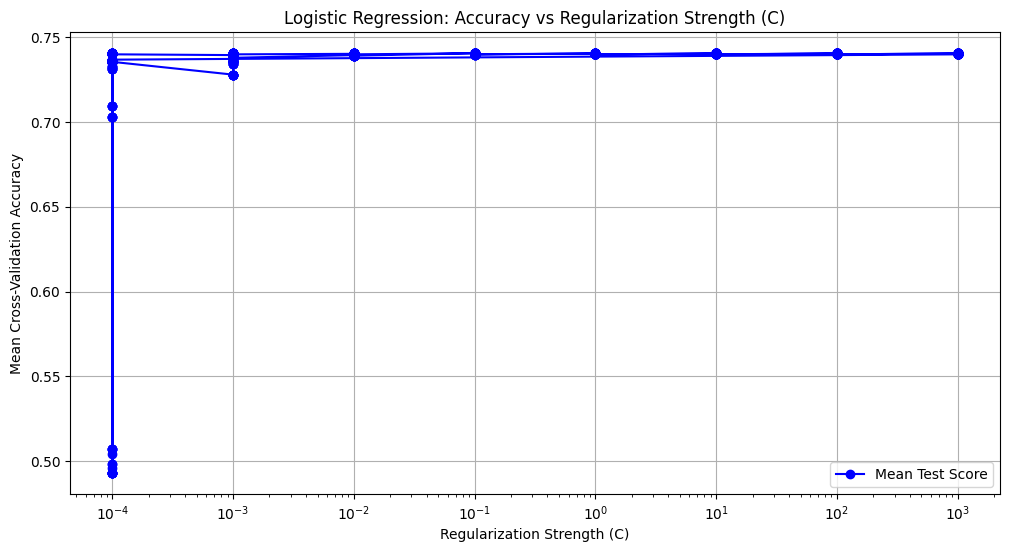

In [14]:
# Trích xuất kết quả từ GridSearchCV
results = pd.DataFrame(lg_grid.cv_results_)

# Vẽ biểu đồ độ chính xác cho mỗi giá trị của 'C' trong grid
plt.figure(figsize=(12, 6))
plt.plot(results['param_C'], results['mean_test_score'], 'bo-', label='Mean Test Score')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Logistic Regression: Accuracy vs Regularization Strength (C)')
plt.xscale('log')  # Vì C có giá trị thay đổi theo cấp số nhân, sử dụng log scale cho trục x
plt.grid(True)
plt.legend()
plt.savefig('../../results/img/accuracy_with_LG_B6_DB03.png',dpi=300, bbox_inches='tight')
plt.show()

In [12]:
import joblib
joblib.dump(lg, '../../results/output_files/B6_improveLG_withDB03.pkl')

['../../results/output_files/B6_improveLG_withDB03.pkl']